In [7]:
%matplotlib inline
import sys
from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../")
    
import numpy as np
from lib.envs.GridEnv import Env
from lib.utils.draw import show_grid,show_policy,draw_line
import matplotlib

env = Env( (20, 20),p=0.4,seed=5,punish=-100)

In [8]:
def get_epsilon_policy(Q,nA,num_episodes):
    
    # 逐渐递减的 eps
    explore_frac = 0.1
    epsilon = lambda i: 1 - 0.99 * min(1, i / (num_episodes * explore_frac))

    def policy_fn(observation,i_episode):
        # eps = epsilon(i_episode)
        eps = 0.1
        A = np.ones(nA) * eps / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1 - eps)
        return A
    return policy_fn

In [9]:
def get_action(policy,state,i_episode):
    probs = policy(state,i_episode)
    action = np.random.choice(range(len(probs)), p=probs)
    return action

In [10]:
def Sarsa_TD_control(env,num_episodes,gamma=0.9,alpha =0.5):
    
    Q = np.zeros( (env.observation_size,env.action_size) )
    policy = get_epsilon_policy(Q,env.action_size,num_episodes)
    
    last_step = 0   
    stats = defaultdict(lambda: [])
    for i_episode in range(num_episodes):
        if i_episode % 10 == 0:
            #\r 实现动态更新
            print(f"\r Episode :{i_episode/num_episodes * 100:.2f}%  last step: {last_step:4}",end = "")
            sys.stdout.flush()
        last_step = 0
        total_reward = 0
        # 
        state = env.reset()
        action = get_action(policy,state,i_episode)
        
        while True:
            last_step += 1
            next_state, reward, done = env.step(action)
            probs = policy(next_state,i_episode)
            next_action = np.random.choice(range(len(probs)), p=probs)
           # print(state,action,reward,next_action)
            # get action expected
            td_expected = 0
            for i_action in range(env.action_size):
                td_expected += probs[i_action] * Q[next_state][i_action]
            td_target = reward + gamma * td_expected
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error
            
            total_reward += reward
            if done:
                break
            state, action = next_state, next_action
        # stats information
        stats['steps'].append(last_step)
        stats['rewards'].append(total_reward)
    
    return Q,stats

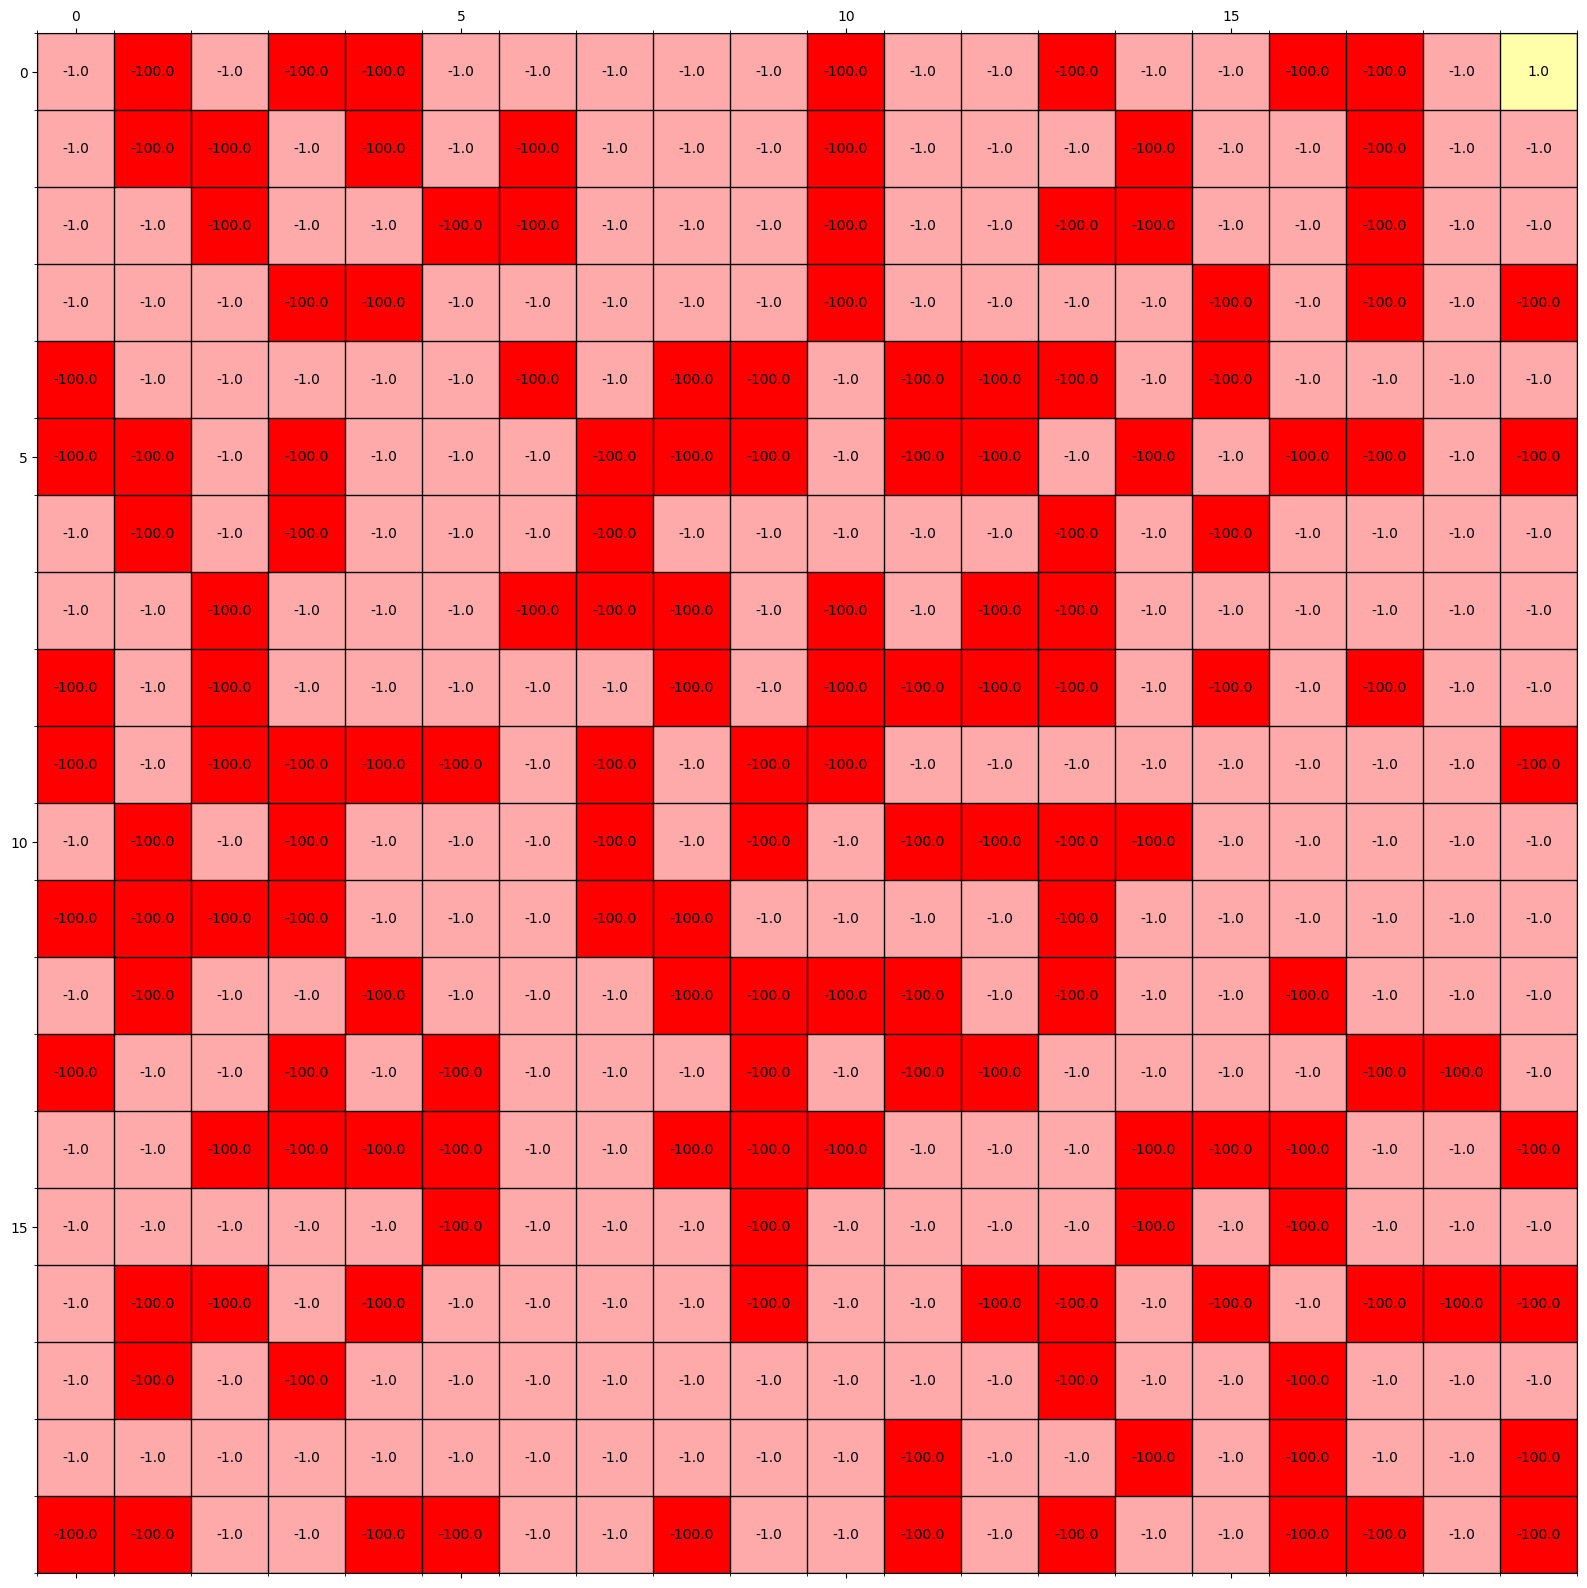

 Episode :96.67%  last step:   76

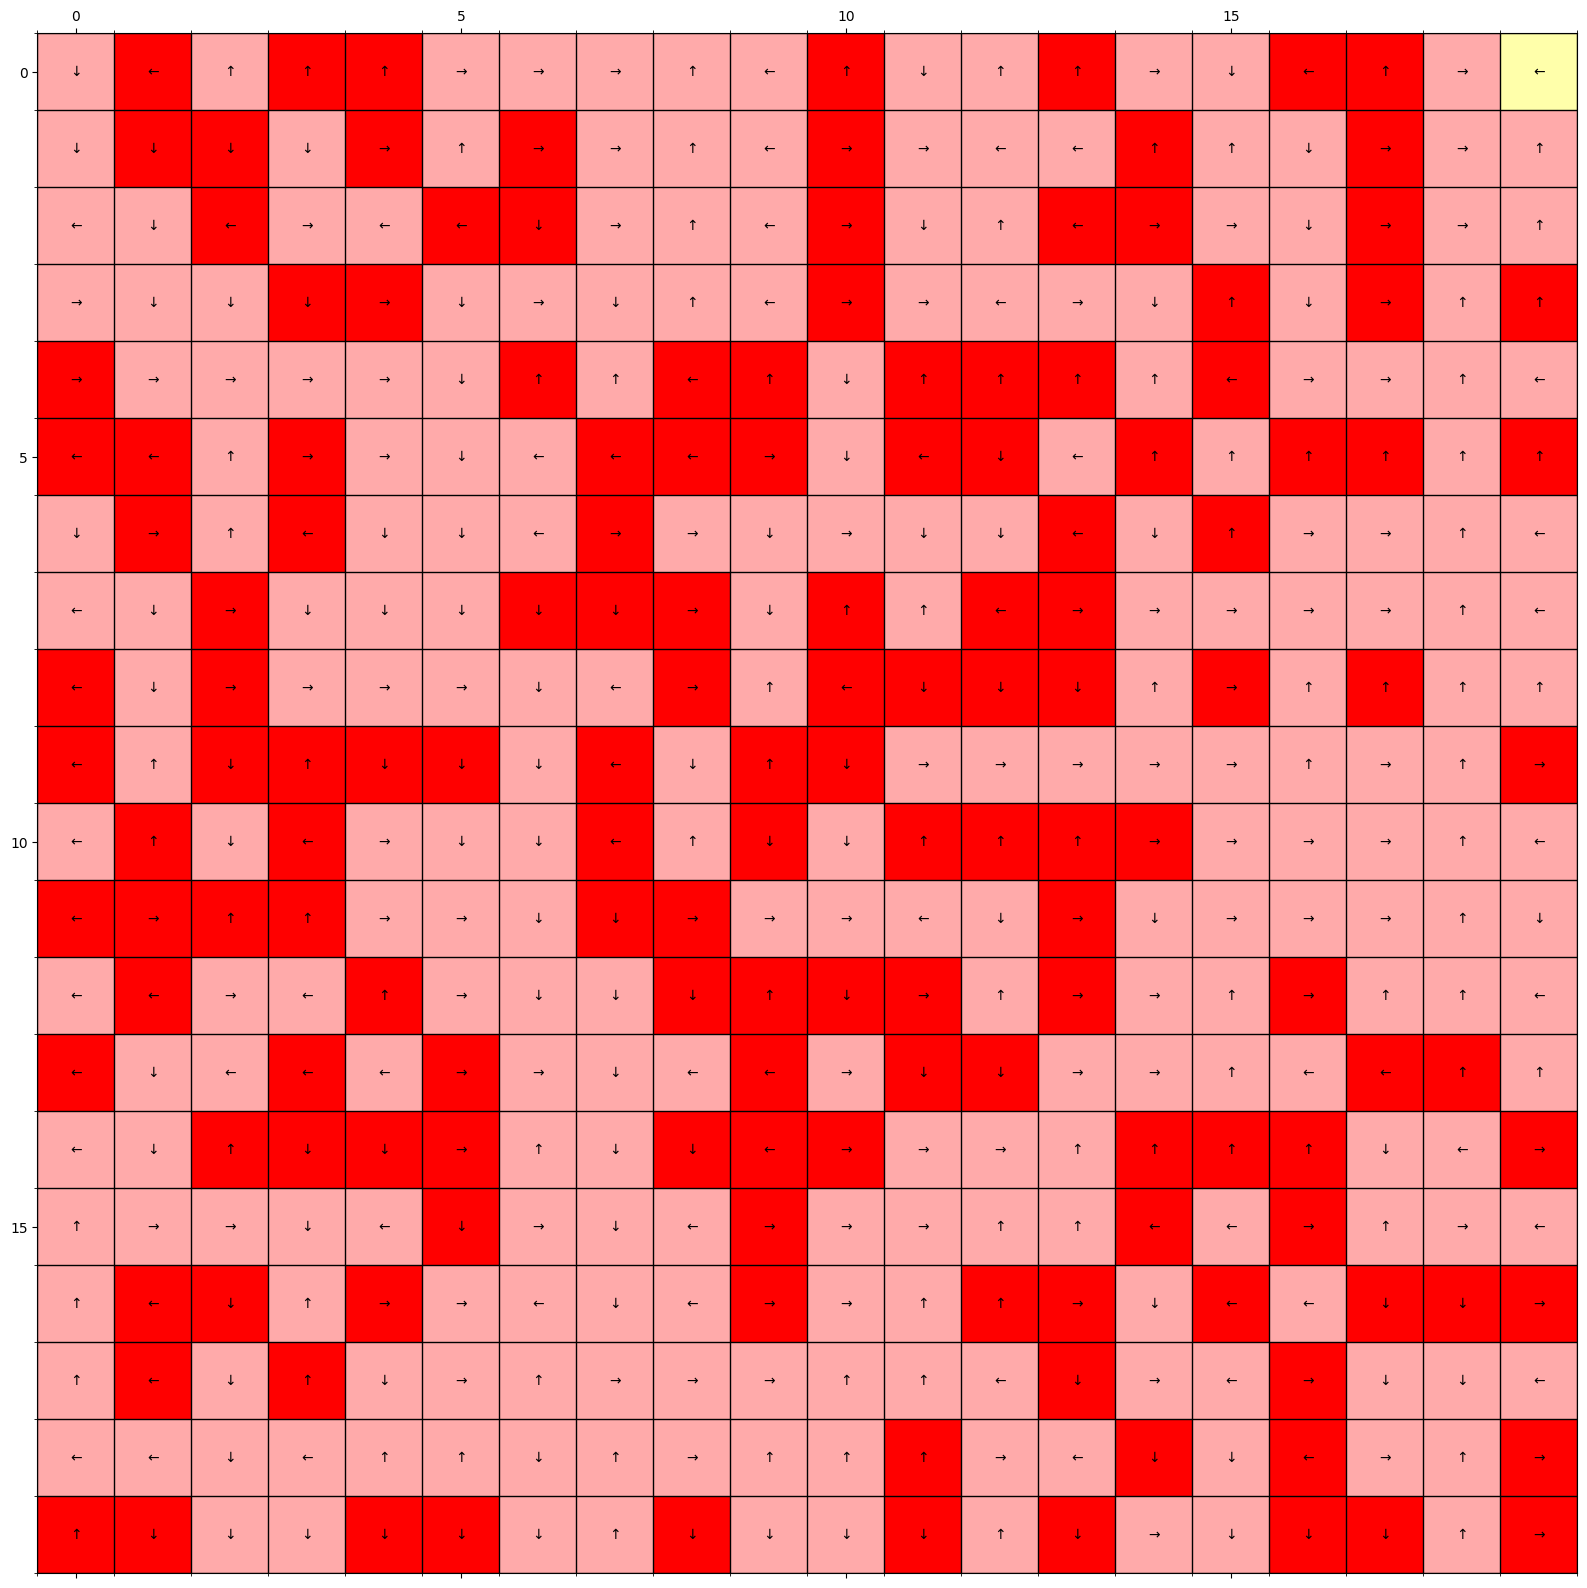

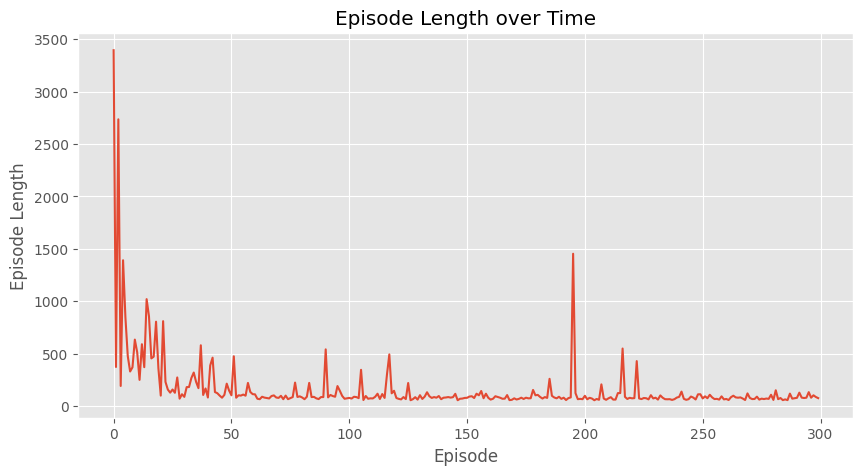

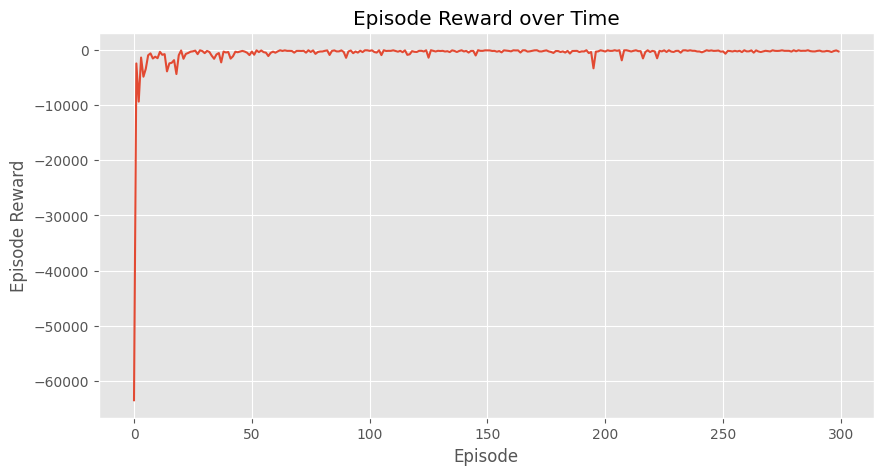

In [11]:
show_grid(env,env.grid)
num_episodes = 300
Q,stats = Sarsa_TD_control(env,num_episodes=num_episodes,gamma=0.99,alpha=1)
V = np.zeros( env.observation_size )
policy = np.zeros_like(Q)
for i in range(len(V)):
    best_action = np.argmax(Q[i])
    V[i] = Q[i][best_action]
    policy[i][best_action] = 1
show_policy(env,policy)
draw_line(stats)


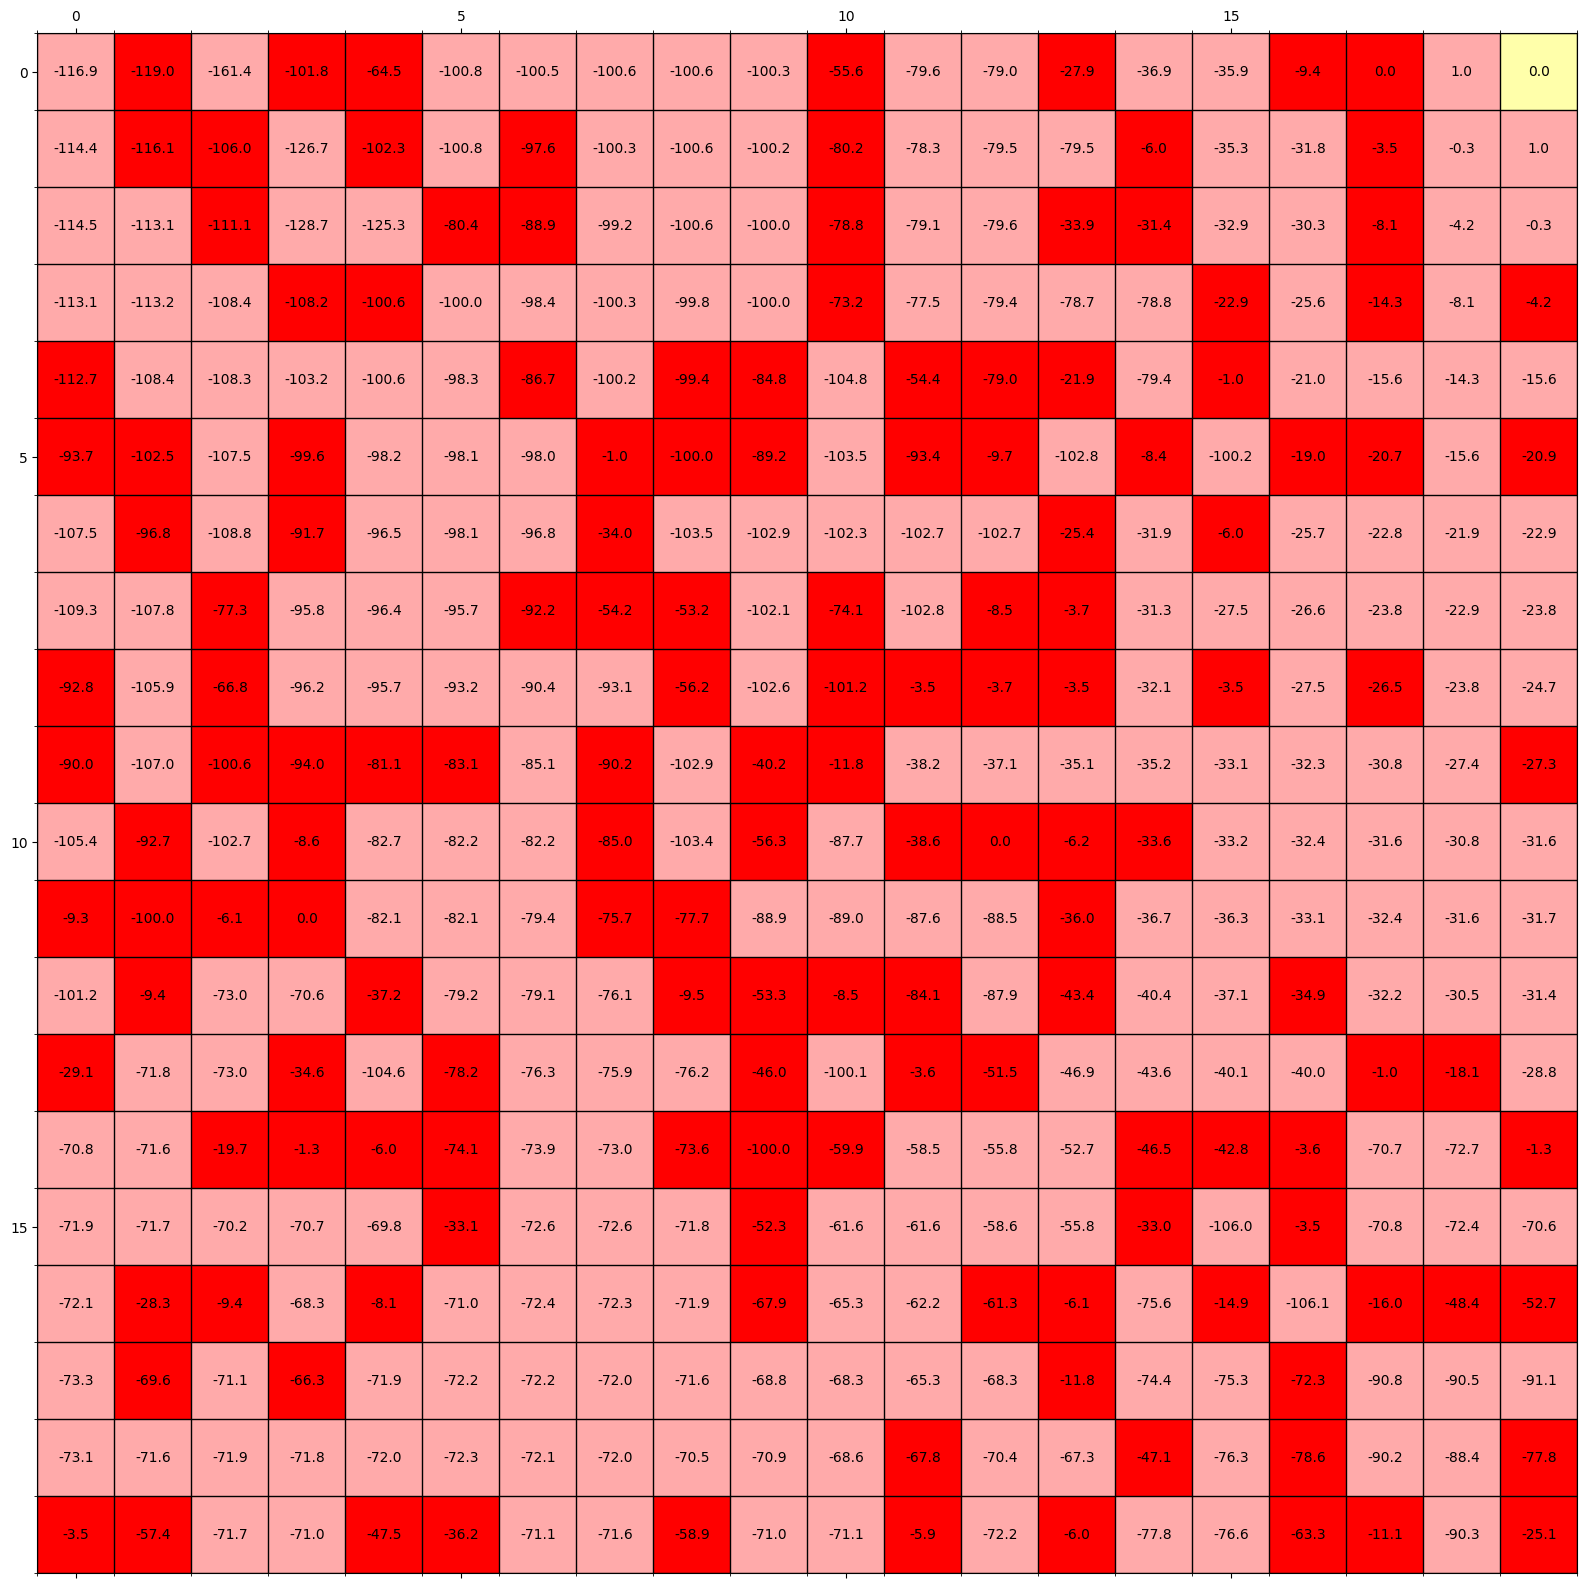

In [12]:
show_grid(env,V)